# ERT

#### TR1 ERT

18/09/25 - 15:44:45 - pyGIMLi - INFO - Cache C:\Users\HOME\anaconda\envs\geophy\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 47): C:\Users\HOME\AppData\Roaming\pygimli\Cache\3796365967003239011
18/09/25 - 15:44:46 - pyGIMLi - INFO - Found 2 regions.
18/09/25 - 15:44:46 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/09/25 - 15:44:46 - pyGIMLi - INFO - Found 2 regions.
18/09/25 - 15:44:46 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/09/25 - 15:44:46 - pyGIMLi - INFO - Creating forward mesh from region infos.


Loaded TR1: electrodes = 21 measurements = 63
Running inversion with params: {'lam': 10.0, 'paraDX': 0.3, 'paraMaxCellSize': 8, 'paraDepth': 40, 'quality': 33.6, 'verbose': True}


18/09/25 - 15:44:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/09/25 - 15:44:46 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 6256 Cells: 12284 Boundaries: 9326
18/09/25 - 15:44:46 - pyGIMLi - INFO - Use median(data values)=26.20428
18/09/25 - 15:44:46 - pyGIMLi - INFO - Created startmodel from forward operator:2112, min/max=26.204280/26.204280
18/09/25 - 15:44:46 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001C3818E6250>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 17.34/60.01
min/max (error): 3%/3%
min/max (start model): 26.2/26.2
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   44.47
--------------------------------------------------------------------------------
chi² =   17.55 (dPhi = 53.57%) lam: 10.0
--------------------------------------------------------------------------------
chi² =   15.25 (dPhi = 12.36%) lam: 10.0
--------------------------------------------------------------------------------
chi² =   14.69 (dPhi = 2.35%) lam: 10.0
--------------------------------------------------------------------------------
chi² =   14.46 (dPhi = 0.46%) lam: 10.0
################################################################################
#                Abort criterion

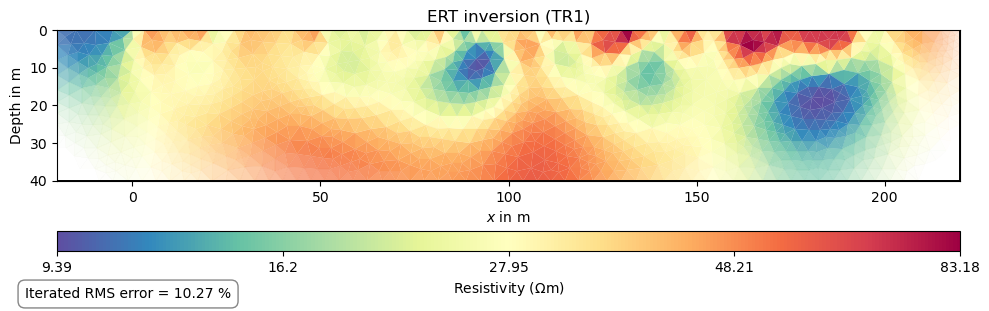

Done. (SAVE_IMAGES = True )


In [12]:
"""
ERT inversion and plotting (pyGIMLi 1.5.x)
- Only ERT inversion and result visualization
- Displays figures (plt.show()). Set SAVE_IMAGES=True to save PNGs too.
- RMS error is printed at the bottom-left with padding and margin.
"""

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert

# -------------------------
# USER CONFIG
# -------------------------
ert_data_file = r"C:\Users\HOME\Desktop\ML Saline\CST\TR1.dat"

out_dir = r"C:\Users\HOME\Desktop\ML Saline\CST\Output"
os.makedirs(out_dir, exist_ok=True)

# Leave inversion params unchanged (as requested)
invert_kwargs = dict(
    lam=10.0,
    paraDX=0.3,
    paraMaxCellSize=8,
    paraDepth=40,
    quality=33.6,
    verbose=True
)

SAVE_IMAGES = True  # default: display only (set True to also save PNGs)

# -------------------------
# Robust pg.DataContainerERT
# -------------------------
def _read_numeric_lines(path):
    lines = []
    with open(path, "r", encoding="utf-8", errors="ignore") as fh:
        for raw in fh:
            s = raw.strip()
            if not s or s.startswith("#"):
                continue
            toks = s.split()
            if len(toks) < 5:
                continue
            ok = True
            for t in toks[:5]:
                try:
                    float(t.replace(",", "."))
                except Exception:
                    ok = False
                    break
            if ok:
                lines.append(" ".join(toks) + "\n")
    return lines

def load_tr1_dat_as_datacontainer(path, default_spacing=10.0):
    lines = _read_numeric_lines(path)
    if not lines:
        raise RuntimeError("No numeric lines found in TR1.dat")
    df = pd.read_csv(io.StringIO("".join(lines)), sep=r"\s+", header=None, engine="python")
    ncols = df.shape[1]

    if ncols >= 8:
        # x y z a b m n rhoa
        x = df.iloc[:, 0].astype(float).to_numpy()
        a = df.iloc[:, 3].astype(float).to_numpy()
        b = df.iloc[:, 4].astype(float).to_numpy()
        m = df.iloc[:, 5].astype(float).to_numpy()
        n = df.iloc[:, 6].astype(float).to_numpy()
        rhoa = df.iloc[:, 7].astype(float).to_numpy()
        unique_x = np.unique(x)
        use_x_positions = unique_x.size > 1
    else:
        # assume a b m n rhoa
        a = df.iloc[:, 0].astype(float).to_numpy()
        b = df.iloc[:, 1].astype(float).to_numpy()
        m = df.iloc[:, 2].astype(float).to_numpy()
        n = df.iloc[:, 3].astype(float).to_numpy()
        rhoa = df.iloc[:, 4].astype(float).to_numpy()
        unique_x = None
        use_x_positions = False

    a_idx = np.rint(a).astype(int)
    b_idx = np.rint(b).astype(int)
    m_idx = np.rint(m).astype(int)
    n_idx = np.rint(n).astype(int)

    if np.min([a_idx.min(), b_idx.min(), m_idx.min(), n_idx.min()]) >= 1:
        a_idx -= 1; b_idx -= 1; m_idx -= 1; n_idx -= 1

    max_elec = int(max(a_idx.max(), b_idx.max(), m_idx.max(), n_idx.max()))
    n_sensors = max_elec + 1

    if use_x_positions and unique_x.size == n_sensors:
        sensor_positions = np.column_stack((unique_x.astype(float), np.zeros(n_sensors, dtype=float)))
    else:
        sensor_positions = np.column_stack((np.arange(n_sensors, dtype=float) * default_spacing, np.zeros(n_sensors, dtype=float)))

    mask = (a_idx >= 0) & (a_idx < n_sensors) & (b_idx >= 0) & (b_idx < n_sensors) & \
           (m_idx >= 0) & (m_idx < n_sensors) & (n_idx >= 0) & (n_idx < n_sensors)
    if np.count_nonzero(~mask) > 0:
        print(f"Dropping {np.count_nonzero(~mask)} out-of-range measurements")
    a_idx, b_idx, m_idx, n_idx, rhoa = a_idx[mask], b_idx[mask], m_idx[mask], n_idx[mask], rhoa[mask]
    if rhoa.size == 0:
        raise RuntimeError("No valid measurements after filtering")

    data = pg.DataContainerERT()
    data.setSensorPositions(sensor_positions.tolist())
    data.resize(len(rhoa))
    data['a'] = a_idx
    data['b'] = b_idx
    data['m'] = m_idx
    data['n'] = n_idx
    data['rhoa'] = rhoa.astype(float)
    data['valid'] = np.ones(len(rhoa), dtype=int)

    try:
        if hasattr(data, "createGeometricFactors"):
            data.createGeometricFactors()
        else:
            data['k'] = np.array(ert.createGeometricFactors(data), dtype=float)
    except Exception as e:
        print("Warning: could not compute geometric factors:", e)
        data['k'] = np.ones(len(rhoa), dtype=float)

    try:
        kvals = np.array(data['k'], dtype=float)
        kvals[kvals == 0] = np.finfo(float).eps
        data['r'] = np.array(data['rhoa'], dtype=float) / kvals
    except Exception:
        pass

    try:
        if hasattr(data, "estimateError"):
            data.estimateError(relativeError=0.03)
        else:
            data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    except Exception:
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9

    print("Loaded TR1: electrodes =", data.sensorCount(), "measurements =", data.size())
    return data

# -------------------------
# Validate datacontainer
# -------------------------
def validate_datacontainer(data):
    if not data.haveData('rhoa'):
        raise RuntimeError("Data container has no 'rhoa'")
    if not data.haveData('k'):
        try:
            data.createGeometricFactors()
        except Exception:
            data['k'] = np.ones(data.size(), dtype=float)
    if not data.haveData('r'):
        try:
            kvals = np.array(data['k'], dtype=float)
            kvals[kvals == 0] = np.finfo(float).eps
            data['r'] = np.array(data['rhoa'], dtype=float) / kvals
        except Exception:
            pass
    if not data.haveData('err'):
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    return data

# -------------------------
# MAIN: produce and show images
# -------------------------
def produce_images_and_show():
    # load ERT
    data = load_tr1_dat_as_datacontainer(ert_data_file)
    data = validate_datacontainer(data)

    # run inversion (unchanged)
    mgr = ert.ERTManager(data)
    print("Running inversion with params:", invert_kwargs)
    mgr.invert(**invert_kwargs)

    # Try retrieving misfit stats
    chi2 = mgr.chi2() if hasattr(mgr, 'chi2') else None
    try:
        rms = mgr.inv.relrms()
    except Exception:
        rms = None

    print("Inversion finished.")
    print("Chi² =", chi2 if chi2 is not None else "N/A")
    print("RMS error =", rms if rms is not None else "N/A")

    # ----- ERT only -----
    fig = plt.figure(figsize=(10, 3.2))
    ax = fig.add_subplot(1, 1, 1)

    mgr.showResult(ax=ax, cMap="Spectral_r", logScale=True, elecs=False)
    ax.set_title("ERT inversion (TR1)")

    # Place RMS at bottom-left of the figure with padding and margin so it doesn't overlap other text
    if rms is not None:
        txt = f"Iterated RMS error = {rms:.2f} %"
        # use figure coordinates so it sits at bottom-left regardless of axis limits
        fig.text(
            0.03, 0.035,
            txt,
            ha="left",
            va="bottom",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.95, edgecolor="0.5")
        )

    if SAVE_IMAGES:
        fig.savefig(os.path.join(out_dir, "TR1_ERT.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    print("Done. (SAVE_IMAGES =", SAVE_IMAGES, ")")

if __name__ == "__main__":
    produce_images_and_show()


#### TR2 ERT

18/09/25 - 15:43:40 - pyGIMLi - INFO - Save RVector binary
18/09/25 - 15:43:40 - pyGIMLi - INFO - Cache stored: C:\Users\HOME\AppData\Roaming\pygimli\Cache\7016812877391491376
18/09/25 - 15:43:40 - pyGIMLi - INFO - Found 2 regions.
18/09/25 - 15:43:40 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/09/25 - 15:43:40 - pyGIMLi - INFO - Found 2 regions.
18/09/25 - 15:43:40 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/09/25 - 15:43:40 - pyGIMLi - INFO - Creating forward mesh from region infos.


Loaded TR1: electrodes = 21 measurements = 36
Running inversion with params: {'lam': 10.0, 'paraDX': 0.3, 'paraMaxCellSize': 8, 'paraDepth': 40, 'quality': 33.6, 'verbose': True}


18/09/25 - 15:43:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/09/25 - 15:43:40 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 6256 Cells: 12284 Boundaries: 9326
18/09/25 - 15:43:41 - pyGIMLi - INFO - Use median(data values)=26.01576
18/09/25 - 15:43:41 - pyGIMLi - INFO - Created startmodel from forward operator:2112, min/max=26.015760/26.015760
18/09/25 - 15:43:41 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001C3A0CCA1B0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 4.52/187
min/max (error): 3%/3%
min/max (start model): 26.02/26.02
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1294.18
--------------------------------------------------------------------------------
chi² =  293.08 (dPhi = 75.71%) lam: 10.0
--------------------------------------------------------------------------------
chi² =   71.92 (dPhi = 67.45%) lam: 10.0
--------------------------------------------------------------------------------
chi² =   44.54 (dPhi = 29.56%) lam: 10.0
--------------------------------------------------------------------------------
chi² =   29.53 (dPhi = 14.98%) lam: 10.0
--------------------------------------------------------------------------------
chi² =   29.75 (dPhi = 0.74%) l

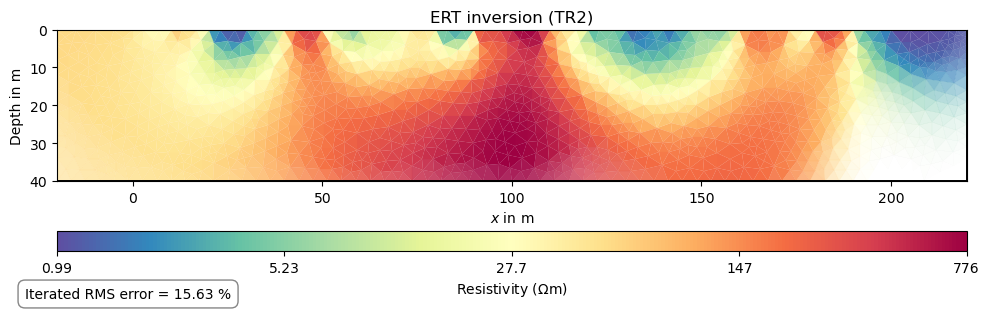

Done. (SAVE_IMAGES = True )


In [11]:
"""
ERT inversion and plotting (pyGIMLi 1.5.x)
- Only ERT inversion and result visualization
- Displays figures (plt.show()). Set SAVE_IMAGES=True to save PNGs too.
- RMS error is printed at the bottom-left with padding and margin.
"""

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert

# -------------------------
# USER CONFIG
# -------------------------
ert_data_file = r"C:\Users\HOME\Desktop\ML Saline\CST\TR2 Reduce.dat"

out_dir = r"C:\Users\HOME\Desktop\ML Saline\CST\Output"
os.makedirs(out_dir, exist_ok=True)

# Leave inversion params unchanged (as requested)
invert_kwargs = dict(
    lam=10.0,
    paraDX=0.3,
    paraMaxCellSize=8,
    paraDepth=40,
    quality=33.6,
    verbose=True
)

SAVE_IMAGES = True  # default: display only (set True to also save PNGs)

# -------------------------
# Robust pg.DataContainerERT
# -------------------------
def _read_numeric_lines(path):
    lines = []
    with open(path, "r", encoding="utf-8", errors="ignore") as fh:
        for raw in fh:
            s = raw.strip()
            if not s or s.startswith("#"):
                continue
            toks = s.split()
            if len(toks) < 5:
                continue
            ok = True
            for t in toks[:5]:
                try:
                    float(t.replace(",", "."))
                except Exception:
                    ok = False
                    break
            if ok:
                lines.append(" ".join(toks) + "\n")
    return lines

def load_tr1_dat_as_datacontainer(path, default_spacing=10.0):
    lines = _read_numeric_lines(path)
    if not lines:
        raise RuntimeError("No numeric lines found in TR2.dat")
    df = pd.read_csv(io.StringIO("".join(lines)), sep=r"\s+", header=None, engine="python")
    ncols = df.shape[1]

    if ncols >= 8:
        # x y z a b m n rhoa
        x = df.iloc[:, 0].astype(float).to_numpy()
        a = df.iloc[:, 3].astype(float).to_numpy()
        b = df.iloc[:, 4].astype(float).to_numpy()
        m = df.iloc[:, 5].astype(float).to_numpy()
        n = df.iloc[:, 6].astype(float).to_numpy()
        rhoa = df.iloc[:, 7].astype(float).to_numpy()
        unique_x = np.unique(x)
        use_x_positions = unique_x.size > 1
    else:
        # assume a b m n rhoa
        a = df.iloc[:, 0].astype(float).to_numpy()
        b = df.iloc[:, 1].astype(float).to_numpy()
        m = df.iloc[:, 2].astype(float).to_numpy()
        n = df.iloc[:, 3].astype(float).to_numpy()
        rhoa = df.iloc[:, 4].astype(float).to_numpy()
        unique_x = None
        use_x_positions = False

    a_idx = np.rint(a).astype(int)
    b_idx = np.rint(b).astype(int)
    m_idx = np.rint(m).astype(int)
    n_idx = np.rint(n).astype(int)

    if np.min([a_idx.min(), b_idx.min(), m_idx.min(), n_idx.min()]) >= 1:
        a_idx -= 1; b_idx -= 1; m_idx -= 1; n_idx -= 1

    max_elec = int(max(a_idx.max(), b_idx.max(), m_idx.max(), n_idx.max()))
    n_sensors = max_elec + 1

    if use_x_positions and unique_x.size == n_sensors:
        sensor_positions = np.column_stack((unique_x.astype(float), np.zeros(n_sensors, dtype=float)))
    else:
        sensor_positions = np.column_stack((np.arange(n_sensors, dtype=float) * default_spacing, np.zeros(n_sensors, dtype=float)))

    mask = (a_idx >= 0) & (a_idx < n_sensors) & (b_idx >= 0) & (b_idx < n_sensors) & \
           (m_idx >= 0) & (m_idx < n_sensors) & (n_idx >= 0) & (n_idx < n_sensors)
    if np.count_nonzero(~mask) > 0:
        print(f"Dropping {np.count_nonzero(~mask)} out-of-range measurements")
    a_idx, b_idx, m_idx, n_idx, rhoa = a_idx[mask], b_idx[mask], m_idx[mask], n_idx[mask], rhoa[mask]
    if rhoa.size == 0:
        raise RuntimeError("No valid measurements after filtering")

    data = pg.DataContainerERT()
    data.setSensorPositions(sensor_positions.tolist())
    data.resize(len(rhoa))
    data['a'] = a_idx
    data['b'] = b_idx
    data['m'] = m_idx
    data['n'] = n_idx
    data['rhoa'] = rhoa.astype(float)
    data['valid'] = np.ones(len(rhoa), dtype=int)

    try:
        if hasattr(data, "createGeometricFactors"):
            data.createGeometricFactors()
        else:
            data['k'] = np.array(ert.createGeometricFactors(data), dtype=float)
    except Exception as e:
        print("Warning: could not compute geometric factors:", e)
        data['k'] = np.ones(len(rhoa), dtype=float)

    try:
        kvals = np.array(data['k'], dtype=float)
        kvals[kvals == 0] = np.finfo(float).eps
        data['r'] = np.array(data['rhoa'], dtype=float) / kvals
    except Exception:
        pass

    try:
        if hasattr(data, "estimateError"):
            data.estimateError(relativeError=0.03)
        else:
            data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    except Exception:
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9

    print("Loaded TR1: electrodes =", data.sensorCount(), "measurements =", data.size())
    return data

# -------------------------
# Validate datacontainer
# -------------------------
def validate_datacontainer(data):
    if not data.haveData('rhoa'):
        raise RuntimeError("Data container has no 'rhoa'")
    if not data.haveData('k'):
        try:
            data.createGeometricFactors()
        except Exception:
            data['k'] = np.ones(data.size(), dtype=float)
    if not data.haveData('r'):
        try:
            kvals = np.array(data['k'], dtype=float)
            kvals[kvals == 0] = np.finfo(float).eps
            data['r'] = np.array(data['rhoa'], dtype=float) / kvals
        except Exception:
            pass
    if not data.haveData('err'):
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    return data

# -------------------------
# MAIN: produce and show images
# -------------------------
def produce_images_and_show():
    # load ERT
    data = load_tr1_dat_as_datacontainer(ert_data_file)
    data = validate_datacontainer(data)

    # run inversion (unchanged)
    mgr = ert.ERTManager(data)
    print("Running inversion with params:", invert_kwargs)
    mgr.invert(**invert_kwargs)

    # Try retrieving misfit stats
    chi2 = mgr.chi2() if hasattr(mgr, 'chi2') else None
    try:
        rms = mgr.inv.relrms()
    except Exception:
        rms = None

    print("Inversion finished.")
    print("Chi² =", chi2 if chi2 is not None else "N/A")
    print("RMS error =", rms if rms is not None else "N/A")

    # ----- ERT only -----
    fig = plt.figure(figsize=(10, 3.2))
    ax = fig.add_subplot(1, 1, 1)

    mgr.showResult(ax=ax, cMap="Spectral_r", logScale=True, elecs=False)
    ax.set_title("ERT inversion (TR2)")

    # Place RMS at bottom-left of the figure with padding and margin so it doesn't overlap other text
    if rms is not None:
        txt = f"Iterated RMS error = {rms:.2f} %"
        # use figure coordinates so it sits at bottom-left regardless of axis limits
        fig.text(
            0.03, 0.035,
            txt,
            ha="left",
            va="bottom",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.95, edgecolor="0.5")
        )

    if SAVE_IMAGES:
        fig.savefig(os.path.join(out_dir, "TR2_ERT.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    print("Done. (SAVE_IMAGES =", SAVE_IMAGES, ")")

if __name__ == "__main__":
    produce_images_and_show()


#### TR3 ERT

18/09/25 - 15:33:10 - pyGIMLi - INFO - Cache C:\Users\HOME\anaconda\envs\geophy\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 1): C:\Users\HOME\AppData\Roaming\pygimli\Cache\4175101634280123927
18/09/25 - 15:33:10 - pyGIMLi - INFO - Found 2 regions.
18/09/25 - 15:33:10 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/09/25 - 15:33:10 - pyGIMLi - INFO - Found 2 regions.
18/09/25 - 15:33:10 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/09/25 - 15:33:10 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/09/25 - 15:33:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Loaded TR1: electrodes = 19 measurements = 41
Running inversion with params: {'lam': 10.0, 'paraDX': 0.3, 'paraMaxCellSize': 8, 'paraDepth': 40, 'quality': 33.6, 'verbose': True}


18/09/25 - 15:33:10 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 6453 Cells: 12664 Boundaries: 9618
18/09/25 - 15:33:11 - pyGIMLi - INFO - Use median(data values)=113.112
18/09/25 - 15:33:11 - pyGIMLi - INFO - Created startmodel from forward operator:1902, min/max=113.112000/113.112000
18/09/25 - 15:33:11 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001C3A0888EA0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 18.47/239
min/max (error): 3%/3%
min/max (start model): 113/113
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  496.99
--------------------------------------------------------------------------------
chi² =   52.36 (dPhi = 88.41%) lam: 10.0
--------------------------------------------------------------------------------
chi² =   13.68 (dPhi = 64.08%) lam: 10.0
--------------------------------------------------------------------------------
chi² =    4.84 (dPhi = 36.12%) lam: 10.0
--------------------------------------------------------------------------------
chi² =    4.44 (dPhi = 2.43%) lam: 10.0
--------------------------------------------------------------------------------
chi² =    4.02 (dPhi = 0.96%) lam: 

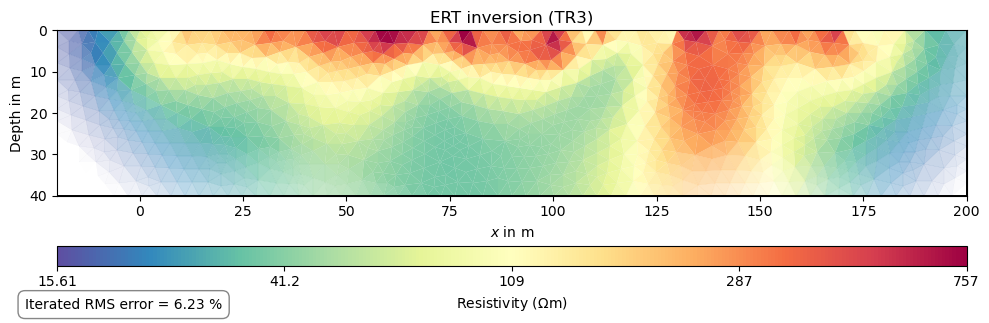

Done. (SAVE_IMAGES = True )


In [8]:
"""
ERT inversion and plotting (pyGIMLi 1.5.x)
- Only ERT inversion and result visualization
- Displays figures (plt.show()). Set SAVE_IMAGES=True to save PNGs too.
- RMS error is printed at the bottom-left with padding and margin.
"""

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert

# -------------------------
# USER CONFIG
# -------------------------
ert_data_file = r"C:\Users\HOME\Desktop\ML Saline\CST\TR3 Reduce.dat"

out_dir = r"C:\Users\HOME\Desktop\ML Saline\CST\Output"
os.makedirs(out_dir, exist_ok=True)

# Leave inversion params unchanged (as requested)
invert_kwargs = dict(
    lam=10.0,
    paraDX=0.3,
    paraMaxCellSize=8,
    paraDepth=40,
    quality=33.6,
    verbose=True
)

SAVE_IMAGES = True  # default: display only (set True to also save PNGs)

# -------------------------
# Robust pg.DataContainerERT
# -------------------------
def _read_numeric_lines(path):
    lines = []
    with open(path, "r", encoding="utf-8", errors="ignore") as fh:
        for raw in fh:
            s = raw.strip()
            if not s or s.startswith("#"):
                continue
            toks = s.split()
            if len(toks) < 5:
                continue
            ok = True
            for t in toks[:5]:
                try:
                    float(t.replace(",", "."))
                except Exception:
                    ok = False
                    break
            if ok:
                lines.append(" ".join(toks) + "\n")
    return lines

def load_tr1_dat_as_datacontainer(path, default_spacing=10.0):
    lines = _read_numeric_lines(path)
    if not lines:
        raise RuntimeError("No numeric lines found in TR3 Reduce.dat")
    df = pd.read_csv(io.StringIO("".join(lines)), sep=r"\s+", header=None, engine="python")
    ncols = df.shape[1]

    if ncols >= 8:
        # x y z a b m n rhoa
        x = df.iloc[:, 0].astype(float).to_numpy()
        a = df.iloc[:, 3].astype(float).to_numpy()
        b = df.iloc[:, 4].astype(float).to_numpy()
        m = df.iloc[:, 5].astype(float).to_numpy()
        n = df.iloc[:, 6].astype(float).to_numpy()
        rhoa = df.iloc[:, 7].astype(float).to_numpy()
        unique_x = np.unique(x)
        use_x_positions = unique_x.size > 1
    else:
        # assume a b m n rhoa
        a = df.iloc[:, 0].astype(float).to_numpy()
        b = df.iloc[:, 1].astype(float).to_numpy()
        m = df.iloc[:, 2].astype(float).to_numpy()
        n = df.iloc[:, 3].astype(float).to_numpy()
        rhoa = df.iloc[:, 4].astype(float).to_numpy()
        unique_x = None
        use_x_positions = False

    a_idx = np.rint(a).astype(int)
    b_idx = np.rint(b).astype(int)
    m_idx = np.rint(m).astype(int)
    n_idx = np.rint(n).astype(int)

    if np.min([a_idx.min(), b_idx.min(), m_idx.min(), n_idx.min()]) >= 1:
        a_idx -= 1; b_idx -= 1; m_idx -= 1; n_idx -= 1

    max_elec = int(max(a_idx.max(), b_idx.max(), m_idx.max(), n_idx.max()))
    n_sensors = max_elec + 1

    if use_x_positions and unique_x.size == n_sensors:
        sensor_positions = np.column_stack((unique_x.astype(float), np.zeros(n_sensors, dtype=float)))
    else:
        sensor_positions = np.column_stack((np.arange(n_sensors, dtype=float) * default_spacing, np.zeros(n_sensors, dtype=float)))

    mask = (a_idx >= 0) & (a_idx < n_sensors) & (b_idx >= 0) & (b_idx < n_sensors) & \
           (m_idx >= 0) & (m_idx < n_sensors) & (n_idx >= 0) & (n_idx < n_sensors)
    if np.count_nonzero(~mask) > 0:
        print(f"Dropping {np.count_nonzero(~mask)} out-of-range measurements")
    a_idx, b_idx, m_idx, n_idx, rhoa = a_idx[mask], b_idx[mask], m_idx[mask], n_idx[mask], rhoa[mask]
    if rhoa.size == 0:
        raise RuntimeError("No valid measurements after filtering")

    data = pg.DataContainerERT()
    data.setSensorPositions(sensor_positions.tolist())
    data.resize(len(rhoa))
    data['a'] = a_idx
    data['b'] = b_idx
    data['m'] = m_idx
    data['n'] = n_idx
    data['rhoa'] = rhoa.astype(float)
    data['valid'] = np.ones(len(rhoa), dtype=int)

    try:
        if hasattr(data, "createGeometricFactors"):
            data.createGeometricFactors()
        else:
            data['k'] = np.array(ert.createGeometricFactors(data), dtype=float)
    except Exception as e:
        print("Warning: could not compute geometric factors:", e)
        data['k'] = np.ones(len(rhoa), dtype=float)

    try:
        kvals = np.array(data['k'], dtype=float)
        kvals[kvals == 0] = np.finfo(float).eps
        data['r'] = np.array(data['rhoa'], dtype=float) / kvals
    except Exception:
        pass

    try:
        if hasattr(data, "estimateError"):
            data.estimateError(relativeError=0.03)
        else:
            data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    except Exception:
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9

    print("Loaded TR1: electrodes =", data.sensorCount(), "measurements =", data.size())
    return data

# -------------------------
# Validate datacontainer
# -------------------------
def validate_datacontainer(data):
    if not data.haveData('rhoa'):
        raise RuntimeError("Data container has no 'rhoa'")
    if not data.haveData('k'):
        try:
            data.createGeometricFactors()
        except Exception:
            data['k'] = np.ones(data.size(), dtype=float)
    if not data.haveData('r'):
        try:
            kvals = np.array(data['k'], dtype=float)
            kvals[kvals == 0] = np.finfo(float).eps
            data['r'] = np.array(data['rhoa'], dtype=float) / kvals
        except Exception:
            pass
    if not data.haveData('err'):
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    return data

# -------------------------
# MAIN: produce and show images
# -------------------------
def produce_images_and_show():
    # load ERT
    data = load_tr1_dat_as_datacontainer(ert_data_file)
    data = validate_datacontainer(data)

    # run inversion (unchanged)
    mgr = ert.ERTManager(data)
    print("Running inversion with params:", invert_kwargs)
    mgr.invert(**invert_kwargs)

    # Try retrieving misfit stats
    chi2 = mgr.chi2() if hasattr(mgr, 'chi2') else None
    try:
        rms = mgr.inv.relrms()
    except Exception:
        rms = None

    print("Inversion finished.")
    print("Chi² =", chi2 if chi2 is not None else "N/A")
    print("RMS error =", rms if rms is not None else "N/A")

    # ----- ERT only -----
    fig = plt.figure(figsize=(10, 3.2))
    ax = fig.add_subplot(1, 1, 1)

    mgr.showResult(ax=ax, cMap="Spectral_r", logScale=True, elecs=False)
    ax.set_title("ERT inversion (TR3)")

    # Place RMS at bottom-left of the figure with padding and margin so it doesn't overlap other text
    if rms is not None:
        txt = f"Iterated RMS error = {rms:.2f} %"
        # use figure coordinates so it sits at bottom-left regardless of axis limits
        fig.text(
            0.03, 0.035,
            txt,
            ha="left",
            va="bottom",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.95, edgecolor="0.5")
        )

    if SAVE_IMAGES:
        fig.savefig(os.path.join(out_dir, "TR3_ERT.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    print("Done. (SAVE_IMAGES =", SAVE_IMAGES, ")")

if __name__ == "__main__":
    produce_images_and_show()


#### TR4 ERT

09/09/25 - 02:09:51 - pyGIMLi - INFO - Save RVector binary
09/09/25 - 02:09:51 - pyGIMLi - INFO - Cache stored: C:\Users\HOME\AppData\Roaming\pygimli\Cache\2939184098791619981
09/09/25 - 02:09:51 - pyGIMLi - INFO - Found 2 regions.
09/09/25 - 02:09:51 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
09/09/25 - 02:09:51 - pyGIMLi - INFO - Found 2 regions.
09/09/25 - 02:09:51 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
09/09/25 - 02:09:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
09/09/25 - 02:09:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Loaded TR1: electrodes = 21 measurements = 63
Running inversion with params: {'lam': 10.0, 'paraDX': 0.3, 'paraMaxCellSize': 8, 'paraDepth': 40, 'quality': 33.6, 'verbose': True}


09/09/25 - 02:09:51 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 6256 Cells: 12284 Boundaries: 9326
09/09/25 - 02:09:51 - pyGIMLi - INFO - Use median(data values)=44.6164
09/09/25 - 02:09:51 - pyGIMLi - INFO - Created startmodel from forward operator:2112, min/max=44.616400/44.616400
09/09/25 - 02:09:51 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000298F73487C0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 1.63/165
min/max (error): 3%/3%
min/max (start model): 44.62/44.62
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 1443.63
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =  106.65 (dPhi = 91.59%) lam: 10.0
--------------------------------------------------------------------------------
chi² =   26.47 (dPhi = 59.32%) lam: 10.0
--------------------------------------------------------------------------------
chi² =   26.14 (dPhi = 1.78%) lam: 10.0
################################################################################
#                Abort criterion reached: dPhi = 1.78 (< 2.0%)                 #
##########################################################

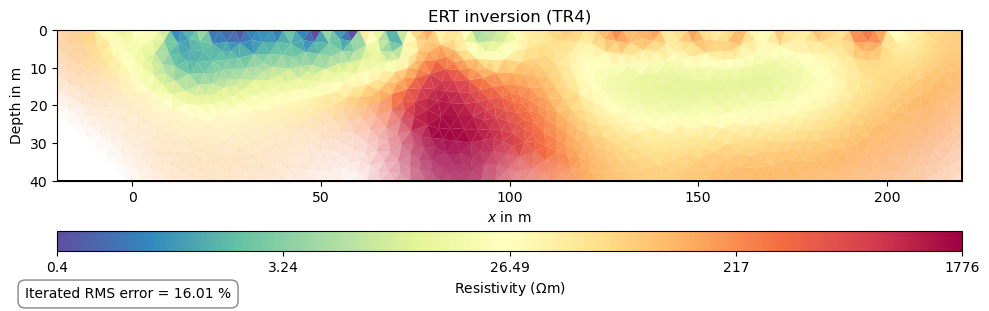

Done. (SAVE_IMAGES = True )


In [5]:
"""
ERT inversion and plotting (pyGIMLi 1.5.x)
- Only ERT inversion and result visualization
- Displays figures (plt.show()). Set SAVE_IMAGES=True to save PNGs too.
- RMS error is printed at the bottom-left with padding and margin.
"""

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert

# -------------------------
# USER CONFIG
# -------------------------
ert_data_file = r"C:\Users\HOME\Desktop\ML Saline\CST\TR4.dat"

out_dir = r"C:\Users\HOME\Desktop\ML Saline\CST\Output"
os.makedirs(out_dir, exist_ok=True)

# Leave inversion params unchanged (as requested)
invert_kwargs = dict(
    lam=10.0,
    paraDX=0.3,
    paraMaxCellSize=8,
    paraDepth=40,
    quality=33.6,
    verbose=True
)

SAVE_IMAGES = True  # default: display only (set True to also save PNGs)

# -------------------------
# Robust pg.DataContainerERT
# -------------------------
def _read_numeric_lines(path):
    lines = []
    with open(path, "r", encoding="utf-8", errors="ignore") as fh:
        for raw in fh:
            s = raw.strip()
            if not s or s.startswith("#"):
                continue
            toks = s.split()
            if len(toks) < 5:
                continue
            ok = True
            for t in toks[:5]:
                try:
                    float(t.replace(",", "."))
                except Exception:
                    ok = False
                    break
            if ok:
                lines.append(" ".join(toks) + "\n")
    return lines

def load_tr1_dat_as_datacontainer(path, default_spacing=10.0):
    lines = _read_numeric_lines(path)
    if not lines:
        raise RuntimeError("No numeric lines found in TR4.dat")
    df = pd.read_csv(io.StringIO("".join(lines)), sep=r"\s+", header=None, engine="python")
    ncols = df.shape[1]

    if ncols >= 8:
        # x y z a b m n rhoa
        x = df.iloc[:, 0].astype(float).to_numpy()
        a = df.iloc[:, 3].astype(float).to_numpy()
        b = df.iloc[:, 4].astype(float).to_numpy()
        m = df.iloc[:, 5].astype(float).to_numpy()
        n = df.iloc[:, 6].astype(float).to_numpy()
        rhoa = df.iloc[:, 7].astype(float).to_numpy()
        unique_x = np.unique(x)
        use_x_positions = unique_x.size > 1
    else:
        # assume a b m n rhoa
        a = df.iloc[:, 0].astype(float).to_numpy()
        b = df.iloc[:, 1].astype(float).to_numpy()
        m = df.iloc[:, 2].astype(float).to_numpy()
        n = df.iloc[:, 3].astype(float).to_numpy()
        rhoa = df.iloc[:, 4].astype(float).to_numpy()
        unique_x = None
        use_x_positions = False

    a_idx = np.rint(a).astype(int)
    b_idx = np.rint(b).astype(int)
    m_idx = np.rint(m).astype(int)
    n_idx = np.rint(n).astype(int)

    if np.min([a_idx.min(), b_idx.min(), m_idx.min(), n_idx.min()]) >= 1:
        a_idx -= 1; b_idx -= 1; m_idx -= 1; n_idx -= 1

    max_elec = int(max(a_idx.max(), b_idx.max(), m_idx.max(), n_idx.max()))
    n_sensors = max_elec + 1

    if use_x_positions and unique_x.size == n_sensors:
        sensor_positions = np.column_stack((unique_x.astype(float), np.zeros(n_sensors, dtype=float)))
    else:
        sensor_positions = np.column_stack((np.arange(n_sensors, dtype=float) * default_spacing, np.zeros(n_sensors, dtype=float)))

    mask = (a_idx >= 0) & (a_idx < n_sensors) & (b_idx >= 0) & (b_idx < n_sensors) & \
           (m_idx >= 0) & (m_idx < n_sensors) & (n_idx >= 0) & (n_idx < n_sensors)
    if np.count_nonzero(~mask) > 0:
        print(f"Dropping {np.count_nonzero(~mask)} out-of-range measurements")
    a_idx, b_idx, m_idx, n_idx, rhoa = a_idx[mask], b_idx[mask], m_idx[mask], n_idx[mask], rhoa[mask]
    if rhoa.size == 0:
        raise RuntimeError("No valid measurements after filtering")

    data = pg.DataContainerERT()
    data.setSensorPositions(sensor_positions.tolist())
    data.resize(len(rhoa))
    data['a'] = a_idx
    data['b'] = b_idx
    data['m'] = m_idx
    data['n'] = n_idx
    data['rhoa'] = rhoa.astype(float)
    data['valid'] = np.ones(len(rhoa), dtype=int)

    try:
        if hasattr(data, "createGeometricFactors"):
            data.createGeometricFactors()
        else:
            data['k'] = np.array(ert.createGeometricFactors(data), dtype=float)
    except Exception as e:
        print("Warning: could not compute geometric factors:", e)
        data['k'] = np.ones(len(rhoa), dtype=float)

    try:
        kvals = np.array(data['k'], dtype=float)
        kvals[kvals == 0] = np.finfo(float).eps
        data['r'] = np.array(data['rhoa'], dtype=float) / kvals
    except Exception:
        pass

    try:
        if hasattr(data, "estimateError"):
            data.estimateError(relativeError=0.03)
        else:
            data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    except Exception:
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9

    print("Loaded TR1: electrodes =", data.sensorCount(), "measurements =", data.size())
    return data

# -------------------------
# Validate datacontainer
# -------------------------
def validate_datacontainer(data):
    if not data.haveData('rhoa'):
        raise RuntimeError("Data container has no 'rhoa'")
    if not data.haveData('k'):
        try:
            data.createGeometricFactors()
        except Exception:
            data['k'] = np.ones(data.size(), dtype=float)
    if not data.haveData('r'):
        try:
            kvals = np.array(data['k'], dtype=float)
            kvals[kvals == 0] = np.finfo(float).eps
            data['r'] = np.array(data['rhoa'], dtype=float) / kvals
        except Exception:
            pass
    if not data.haveData('err'):
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    return data

# -------------------------
# MAIN: produce and show images
# -------------------------
def produce_images_and_show():
    # load ERT
    data = load_tr1_dat_as_datacontainer(ert_data_file)
    data = validate_datacontainer(data)

    # run inversion (unchanged)
    mgr = ert.ERTManager(data)
    print("Running inversion with params:", invert_kwargs)
    mgr.invert(**invert_kwargs)

    # Try retrieving misfit stats
    chi2 = mgr.chi2() if hasattr(mgr, 'chi2') else None
    try:
        rms = mgr.inv.relrms()
    except Exception:
        rms = None

    print("Inversion finished.")
    print("Chi² =", chi2 if chi2 is not None else "N/A")
    print("RMS error =", rms if rms is not None else "N/A")

    # ----- ERT only -----
    fig = plt.figure(figsize=(10, 3.2))
    ax = fig.add_subplot(1, 1, 1)

    mgr.showResult(ax=ax, cMap="Spectral_r", logScale=True, elecs=False)
    ax.set_title("ERT inversion (TR4)")

    # Place RMS at bottom-left of the figure with padding and margin so it doesn't overlap other text
    if rms is not None:
        txt = f"Iterated RMS error = {rms:.2f} %"
        # use figure coordinates so it sits at bottom-left regardless of axis limits
        fig.text(
            0.03, 0.035,
            txt,
            ha="left",
            va="bottom",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.95, edgecolor="0.5")
        )

    if SAVE_IMAGES:
        fig.savefig(os.path.join(out_dir, "TR4_ERT.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    print("Done. (SAVE_IMAGES =", SAVE_IMAGES, ")")

if __name__ == "__main__":
    produce_images_and_show()


#### TR5 ERT

09/09/25 - 02:10:12 - pyGIMLi - INFO - Save RVector binary
09/09/25 - 02:10:12 - pyGIMLi - INFO - Cache stored: C:\Users\HOME\AppData\Roaming\pygimli\Cache\2375823304724825005
09/09/25 - 02:10:12 - pyGIMLi - INFO - Found 2 regions.
09/09/25 - 02:10:12 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
09/09/25 - 02:10:12 - pyGIMLi - INFO - Found 2 regions.
09/09/25 - 02:10:12 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
09/09/25 - 02:10:12 - pyGIMLi - INFO - Creating forward mesh from region infos.
09/09/25 - 02:10:12 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Loaded TR1: electrodes = 17 measurements = 40
Running inversion with params: {'lam': 10.0, 'paraDX': 0.3, 'paraMaxCellSize': 8, 'paraDepth': 40, 'quality': 33.6, 'verbose': True}


09/09/25 - 02:10:12 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 5417 Cells: 10624 Boundaries: 8072
09/09/25 - 02:10:13 - pyGIMLi - INFO - Use median(data values)=43.17108
09/09/25 - 02:10:13 - pyGIMLi - INFO - Created startmodel from forward operator:1751, min/max=43.171080/43.171080
09/09/25 - 02:10:13 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000298F6F61E40>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 17.22/75.41
min/max (error): 3%/3%
min/max (start model): 43.17/43.17
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  127.56
--------------------------------------------------------------------------------
chi² =   25.93 (dPhi = 75.35%) lam: 10.0
--------------------------------------------------------------------------------
chi² =    4.67 (dPhi = 63.50%) lam: 10.0
--------------------------------------------------------------------------------
chi² =    3.60 (dPhi = 6.96%) lam: 10.0
--------------------------------------------------------------------------------
chi² =    3.39 (dPhi = 1.20%) lam: 10.0
################################################################################
#                 Abort criter

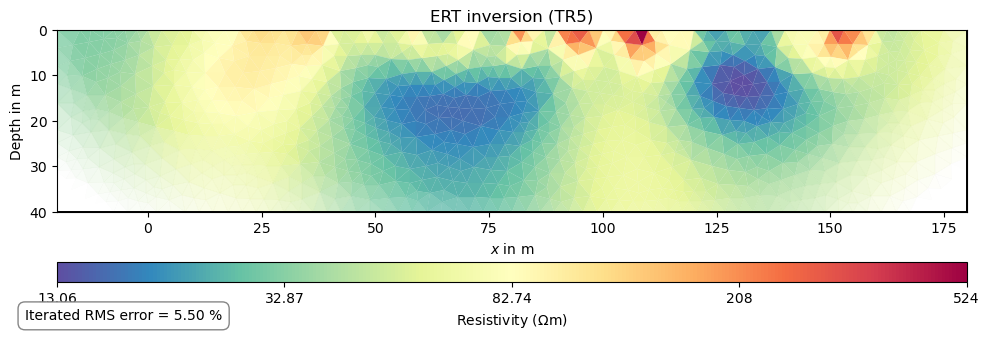

Done. (SAVE_IMAGES = True )


In [6]:
"""
ERT inversion and plotting (pyGIMLi 1.5.x)
- Only ERT inversion and result visualization
- Displays figures (plt.show()). Set SAVE_IMAGES=True to save PNGs too.
- RMS error is printed at the bottom-left with padding and margin.
"""

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert

# -------------------------
# USER CONFIG
# -------------------------
ert_data_file = r"C:\Users\HOME\Desktop\ML Saline\CST\TR5.dat"

out_dir = r"C:\Users\HOME\Desktop\ML Saline\CST\Output"
os.makedirs(out_dir, exist_ok=True)

# Leave inversion params unchanged (as requested)
invert_kwargs = dict(
    lam=10.0,
    paraDX=0.3,
    paraMaxCellSize=8,
    paraDepth=40,
    quality=33.6,
    verbose=True
)

SAVE_IMAGES = True  # default: display only (set True to also save PNGs)

# -------------------------
# Robust pg.DataContainerERT
# -------------------------
def _read_numeric_lines(path):
    lines = []
    with open(path, "r", encoding="utf-8", errors="ignore") as fh:
        for raw in fh:
            s = raw.strip()
            if not s or s.startswith("#"):
                continue
            toks = s.split()
            if len(toks) < 5:
                continue
            ok = True
            for t in toks[:5]:
                try:
                    float(t.replace(",", "."))
                except Exception:
                    ok = False
                    break
            if ok:
                lines.append(" ".join(toks) + "\n")
    return lines

def load_tr1_dat_as_datacontainer(path, default_spacing=10.0):
    lines = _read_numeric_lines(path)
    if not lines:
        raise RuntimeError("No numeric lines found in TR5.dat")
    df = pd.read_csv(io.StringIO("".join(lines)), sep=r"\s+", header=None, engine="python")
    ncols = df.shape[1]

    if ncols >= 8:
        # x y z a b m n rhoa
        x = df.iloc[:, 0].astype(float).to_numpy()
        a = df.iloc[:, 3].astype(float).to_numpy()
        b = df.iloc[:, 4].astype(float).to_numpy()
        m = df.iloc[:, 5].astype(float).to_numpy()
        n = df.iloc[:, 6].astype(float).to_numpy()
        rhoa = df.iloc[:, 7].astype(float).to_numpy()
        unique_x = np.unique(x)
        use_x_positions = unique_x.size > 1
    else:
        # assume a b m n rhoa
        a = df.iloc[:, 0].astype(float).to_numpy()
        b = df.iloc[:, 1].astype(float).to_numpy()
        m = df.iloc[:, 2].astype(float).to_numpy()
        n = df.iloc[:, 3].astype(float).to_numpy()
        rhoa = df.iloc[:, 4].astype(float).to_numpy()
        unique_x = None
        use_x_positions = False

    a_idx = np.rint(a).astype(int)
    b_idx = np.rint(b).astype(int)
    m_idx = np.rint(m).astype(int)
    n_idx = np.rint(n).astype(int)

    if np.min([a_idx.min(), b_idx.min(), m_idx.min(), n_idx.min()]) >= 1:
        a_idx -= 1; b_idx -= 1; m_idx -= 1; n_idx -= 1

    max_elec = int(max(a_idx.max(), b_idx.max(), m_idx.max(), n_idx.max()))
    n_sensors = max_elec + 1

    if use_x_positions and unique_x.size == n_sensors:
        sensor_positions = np.column_stack((unique_x.astype(float), np.zeros(n_sensors, dtype=float)))
    else:
        sensor_positions = np.column_stack((np.arange(n_sensors, dtype=float) * default_spacing, np.zeros(n_sensors, dtype=float)))

    mask = (a_idx >= 0) & (a_idx < n_sensors) & (b_idx >= 0) & (b_idx < n_sensors) & \
           (m_idx >= 0) & (m_idx < n_sensors) & (n_idx >= 0) & (n_idx < n_sensors)
    if np.count_nonzero(~mask) > 0:
        print(f"Dropping {np.count_nonzero(~mask)} out-of-range measurements")
    a_idx, b_idx, m_idx, n_idx, rhoa = a_idx[mask], b_idx[mask], m_idx[mask], n_idx[mask], rhoa[mask]
    if rhoa.size == 0:
        raise RuntimeError("No valid measurements after filtering")

    data = pg.DataContainerERT()
    data.setSensorPositions(sensor_positions.tolist())
    data.resize(len(rhoa))
    data['a'] = a_idx
    data['b'] = b_idx
    data['m'] = m_idx
    data['n'] = n_idx
    data['rhoa'] = rhoa.astype(float)
    data['valid'] = np.ones(len(rhoa), dtype=int)

    try:
        if hasattr(data, "createGeometricFactors"):
            data.createGeometricFactors()
        else:
            data['k'] = np.array(ert.createGeometricFactors(data), dtype=float)
    except Exception as e:
        print("Warning: could not compute geometric factors:", e)
        data['k'] = np.ones(len(rhoa), dtype=float)

    try:
        kvals = np.array(data['k'], dtype=float)
        kvals[kvals == 0] = np.finfo(float).eps
        data['r'] = np.array(data['rhoa'], dtype=float) / kvals
    except Exception:
        pass

    try:
        if hasattr(data, "estimateError"):
            data.estimateError(relativeError=0.03)
        else:
            data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    except Exception:
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9

    print("Loaded TR1: electrodes =", data.sensorCount(), "measurements =", data.size())
    return data

# -------------------------
# Validate datacontainer
# -------------------------
def validate_datacontainer(data):
    if not data.haveData('rhoa'):
        raise RuntimeError("Data container has no 'rhoa'")
    if not data.haveData('k'):
        try:
            data.createGeometricFactors()
        except Exception:
            data['k'] = np.ones(data.size(), dtype=float)
    if not data.haveData('r'):
        try:
            kvals = np.array(data['k'], dtype=float)
            kvals[kvals == 0] = np.finfo(float).eps
            data['r'] = np.array(data['rhoa'], dtype=float) / kvals
        except Exception:
            pass
    if not data.haveData('err'):
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    return data

# -------------------------
# MAIN: produce and show images
# -------------------------
def produce_images_and_show():
    # load ERT
    data = load_tr1_dat_as_datacontainer(ert_data_file)
    data = validate_datacontainer(data)

    # run inversion (unchanged)
    mgr = ert.ERTManager(data)
    print("Running inversion with params:", invert_kwargs)
    mgr.invert(**invert_kwargs)

    # Try retrieving misfit stats
    chi2 = mgr.chi2() if hasattr(mgr, 'chi2') else None
    try:
        rms = mgr.inv.relrms()
    except Exception:
        rms = None

    print("Inversion finished.")
    print("Chi² =", chi2 if chi2 is not None else "N/A")
    print("RMS error =", rms if rms is not None else "N/A")

    # ----- ERT only -----
    fig = plt.figure(figsize=(10, 3.2))
    ax = fig.add_subplot(1, 1, 1)

    mgr.showResult(ax=ax, cMap="Spectral_r", logScale=True, elecs=False)
    ax.set_title("ERT inversion (TR5)")

    # Place RMS at bottom-left of the figure with padding and margin so it doesn't overlap other text
    if rms is not None:
        txt = f"Iterated RMS error = {rms:.2f} %"
        # use figure coordinates so it sits at bottom-left regardless of axis limits
        fig.text(
            0.03, 0.035,
            txt,
            ha="left",
            va="bottom",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.95, edgecolor="0.5")
        )

    if SAVE_IMAGES:
        fig.savefig(os.path.join(out_dir, "TR5_ERT.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    print("Done. (SAVE_IMAGES =", SAVE_IMAGES, ")")

if __name__ == "__main__":
    produce_images_and_show()


21/09/25 - 16:47:45 - pyGIMLi - INFO - Cache C:\Users\HOME\anaconda\envs\geophy\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 61): C:\Users\HOME\AppData\Roaming\pygimli\Cache\3796365967003239011
21/09/25 - 16:47:46 - pyGIMLi - INFO - Found 2 regions.
21/09/25 - 16:47:46 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
21/09/25 - 16:47:46 - pyGIMLi - INFO - Found 2 regions.
21/09/25 - 16:47:46 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
21/09/25 - 16:47:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
21/09/25 - 16:47:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Loaded TR1: electrodes = 21 measurements = 63
Running inversion with params: {'lam': 10.0, 'paraDX': 0.3, 'paraMaxCellSize': 8, 'paraDepth': 40, 'quality': 33.6, 'verbose': True}


21/09/25 - 16:47:46 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 6256 Cells: 12284 Boundaries: 9326
21/09/25 - 16:47:46 - pyGIMLi - INFO - Use median(data values)=26.20428
21/09/25 - 16:47:46 - pyGIMLi - INFO - Created startmodel from forward operator:2112, min/max=26.204280/26.204280
21/09/25 - 16:47:46 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002BF15C9D210>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 17.34/60.01
min/max (error): 3%/3%
min/max (start model): 26.2/26.2
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =   44.47
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   17.55 (dPhi = 53.57%) lam: 10.0
--------------------------------------------------------------------------------
chi² =   15.25 (dPhi = 12.36%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   14.69 (dPhi = 2.35%) lam: 10.0
--------------------------------------------------------------------------------
chi² =   14.46 (dPhi = 0.46%) lam: 10.0
################################################################################
# 

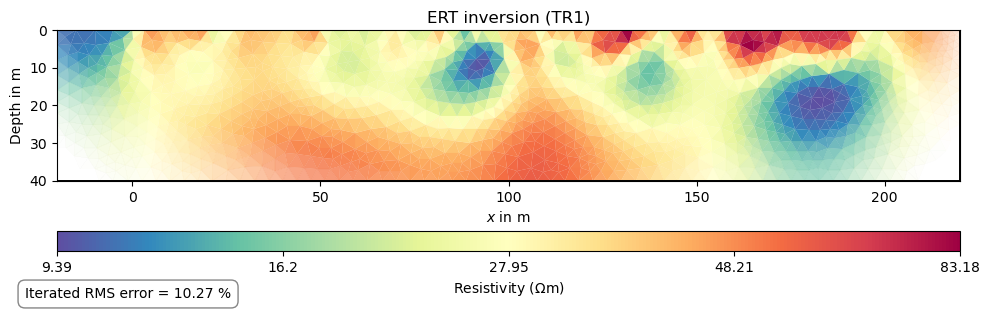

Done. (SAVE_IMAGES = True )


In [7]:
# ERT inversion and plotting (pyGIMLi 1.5.x)
# - Only ERT inversion and result visualization
# - Displays figures (plt.show()). Set SAVE_IMAGES=True to save PNGs too.
# - RMS error is printed at the bottom-left with padding and margin.
# - Added functionality to export inverted model data to Excel

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert

# -------------------------
# USER CONFIG
# -------------------------
ert_data_file = r"C:\Users\HOME\Desktop\ML Saline\CST\TR1.dat"

out_dir = r"C:\Users\HOME\Desktop\ML Saline\CST\Output"
os.makedirs(out_dir, exist_ok=True)

# Leave inversion params unchanged (as requested)
invert_kwargs = dict(
    lam=10.0,
    paraDX=0.3,
    paraMaxCellSize=8,
    paraDepth=40,
    quality=33.6,
    verbose=True
)

SAVE_IMAGES = True  # default: display only (set True to also save PNGs)

# -------------------------
# Robust pg.DataContainerERT
# -------------------------
def _read_numeric_lines(path):
    lines = []
    with open(path, "r", encoding="utf-8", errors="ignore") as fh:
        for raw in fh:
            s = raw.strip()
            if not s or s.startswith("#"):
                continue
            toks = s.split()
            if len(toks) < 5:
                continue
            ok = True
            for t in toks[:5]:
                try:
                    float(t.replace(",", "."))
                except Exception:
                    ok = False
                    break
            if ok:
                lines.append(" ".join(toks) + "\n")
    return lines

def load_tr1_dat_as_datacontainer(path, default_spacing=10.0):
    lines = _read_numeric_lines(path)
    if not lines:
        raise RuntimeError("No numeric lines found in TR1.dat")
    df = pd.read_csv(io.StringIO("".join(lines)), sep=r"\s+", header=None, engine="python")
    ncols = df.shape[1]

    if ncols >= 8:
        # x y z a b m n rhoa
        x = df.iloc[:, 0].astype(float).to_numpy()
        a = df.iloc[:, 3].astype(float).to_numpy()
        b = df.iloc[:, 4].astype(float).to_numpy()
        m = df.iloc[:, 5].astype(float).to_numpy()
        n = df.iloc[:, 6].astype(float).to_numpy()
        rhoa = df.iloc[:, 7].astype(float).to_numpy()
        unique_x = np.unique(x)
        use_x_positions = unique_x.size > 1
    else:
        # assume a b m n rhoa
        a = df.iloc[:, 0].astype(float).to_numpy()
        b = df.iloc[:, 1].astype(float).to_numpy()
        m = df.iloc[:, 2].astype(float).to_numpy()
        n = df.iloc[:, 3].astype(float).to_numpy()
        rhoa = df.iloc[:, 4].astype(float).to_numpy()
        unique_x = None
        use_x_positions = False

    a_idx = np.rint(a).astype(int)
    b_idx = np.rint(b).astype(int)
    m_idx = np.rint(m).astype(int)
    n_idx = np.rint(n).astype(int)

    if np.min([a_idx.min(), b_idx.min(), m_idx.min(), n_idx.min()]) >= 1:
        a_idx -= 1; b_idx -= 1; m_idx -= 1; n_idx -= 1

    max_elec = int(max(a_idx.max(), b_idx.max(), m_idx.max(), n_idx.max()))
    n_sensors = max_elec + 1

    if use_x_positions and unique_x.size == n_sensors:
        sensor_positions = np.column_stack((unique_x.astype(float), np.zeros(n_sensors, dtype=float)))
    else:
        sensor_positions = np.column_stack((np.arange(n_sensors, dtype=float) * default_spacing, np.zeros(n_sensors, dtype=float)))

    mask = (a_idx >= 0) & (a_idx < n_sensors) & (b_idx >= 0) & (b_idx < n_sensors) & \
           (m_idx >= 0) & (m_idx < n_sensors) & (n_idx >= 0) & (n_idx < n_sensors)
    if np.count_nonzero(~mask) > 0:
        print(f"Dropping {np.count_nonzero(~mask)} out-of-range measurements")
    a_idx, b_idx, m_idx, n_idx, rhoa = a_idx[mask], b_idx[mask], m_idx[mask], n_idx[mask], rhoa[mask]
    if rhoa.size == 0:
        raise RuntimeError("No valid measurements after filtering")

    data = pg.DataContainerERT()
    data.setSensorPositions(sensor_positions.tolist())
    data.resize(len(rhoa))
    data['a'] = a_idx
    data['b'] = b_idx
    data['m'] = m_idx
    data['n'] = n_idx
    data['rhoa'] = rhoa.astype(float)
    data['valid'] = np.ones(len(rhoa), dtype=int)

    try:
        if hasattr(data, "createGeometricFactors"):
            data.createGeometricFactors()
        else:
            data['k'] = np.array(ert.createGeometricFactors(data), dtype=float)
    except Exception as e:
        print("Warning: could not compute geometric factors:", e)
        data['k'] = np.ones(len(rhoa), dtype=float)

    try:
        kvals = np.array(data['k'], dtype=float)
        kvals[kvals == 0] = np.finfo(float).eps
        data['r'] = np.array(data['rhoa'], dtype=float) / kvals
    except Exception:
        pass

    try:
        if hasattr(data, "estimateError"):
            data.estimateError(relativeError=0.03)
        else:
            data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    except Exception:
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9

    print("Loaded TR1: electrodes =", data.sensorCount(), "measurements =", data.size())
    return data

# -------------------------
# Validate datacontainer
# -------------------------
def validate_datacontainer(data):
    if not data.haveData('rhoa'):
        raise RuntimeError("Data container has no 'rhoa'")
    if not data.haveData('k'):
        try:
            data.createGeometricFactors()
        except Exception:
            data['k'] = np.ones(data.size(), dtype=float)
    if not data.haveData('r'):
        try:
            kvals = np.array(data['k'], dtype=float)
            kvals[kvals == 0] = np.finfo(float).eps
            data['r'] = np.array(data['rhoa'], dtype=float) / kvals
        except Exception:
            pass
    if not data.haveData('err'):
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    return data

# -------------------------
# MAIN: produce and show images
# -------------------------
def produce_images_and_show():
    # load ERT
    data = load_tr1_dat_as_datacontainer(ert_data_file)
    data = validate_datacontainer(data)

    # run inversion (unchanged)
    mgr = ert.ERTManager(data)
    print("Running inversion with params:", invert_kwargs)
    mgr.invert(**invert_kwargs)

    # Try retrieving misfit stats
    chi2 = mgr.chi2() if hasattr(mgr, 'chi2') else None
    try:
        rms = mgr.inv.relrms()
    except Exception:
        rms = None

    print("Inversion finished.")
    print("Chi² =", chi2 if chi2 is not None else "N/A")
    print("RMS error =", rms if rms is not None else "N/A")

    # ----- Export inverted model data to Excel -----
    if SAVE_IMAGES:
        try:
            # Get the inversion mesh and model values
            mesh = mgr.paraDomain  # Parametric domain mesh
            model_vals = mgr.model  # Resistivity values in Ohm-m

            # Extract cell centers (x, z coordinates)
            cells = mesh.cells()
            x_vals = []
            z_vals = []
            rho_vals = []
            for cell in cells:
                center = cell.center()
                x_vals.append(center.x())
                z_vals.append(center.y())  # Depth is negative in y-direction
                rho_vals.append(model_vals[cell.id()])

            # Create a DataFrame
            df_inv = pd.DataFrame({
                'X (m)': x_vals,
                'Depth (m)': z_vals,
                'Resistivity (Ohm-m)': rho_vals
            })

            # Save to Excel
            excel_path = os.path.join(out_dir, "TR1_Inverted_Model_Data.xlsx")
            df_inv.to_excel(excel_path, index=False)
            print(f"Inverted model data saved to: {excel_path}")
        except Exception as e:
            print(f"Error saving inverted data to Excel: {e}")

    # ----- ERT only -----
    fig = plt.figure(figsize=(10, 3.2))
    ax = fig.add_subplot(1, 1, 1)

    # Show result with fixed resistivity range (1-800 Ohm-m)
    mgr.showResult(ax=ax, cMap="Spectral_r", logScale=True, elecs=False) 
    ax.set_title("ERT inversion (TR1)")

    # Place RMS at bottom-left of the figure with padding and margin so it doesn't overlap other text
    if rms is not None:
        txt = f"Iterated RMS error = {rms:.2f} %"
        # use figure coordinates so it sits at bottom-left regardless of axis limits
        fig.text(
            0.03, 0.035,
            txt,
            ha="left",
            va="bottom",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.95, edgecolor="0.5")
        )

    if SAVE_IMAGES:
        fig.savefig(os.path.join(out_dir, "TR1_ERT.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    print("Done. (SAVE_IMAGES =", SAVE_IMAGES, ")")

if __name__ == "__main__":
    produce_images_and_show()

21/09/25 - 16:51:06 - pyGIMLi - INFO - Cache C:\Users\HOME\anaconda\envs\geophy\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 1): C:\Users\HOME\AppData\Roaming\pygimli\Cache\2375823304724825005
21/09/25 - 16:51:06 - pyGIMLi - INFO - Found 2 regions.
21/09/25 - 16:51:06 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
21/09/25 - 16:51:07 - pyGIMLi - INFO - Found 2 regions.
21/09/25 - 16:51:07 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
21/09/25 - 16:51:07 - pyGIMLi - INFO - Creating forward mesh from region infos.
21/09/25 - 16:51:07 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Loaded TR1: electrodes = 17 measurements = 40
Running inversion with params: {'lam': 10.0, 'paraDX': 0.3, 'paraMaxCellSize': 8, 'paraDepth': 40, 'quality': 33.6, 'verbose': True}


21/09/25 - 16:51:07 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 5417 Cells: 10624 Boundaries: 8072
21/09/25 - 16:51:07 - pyGIMLi - INFO - Use median(data values)=43.17108
21/09/25 - 16:51:07 - pyGIMLi - INFO - Created startmodel from forward operator:1751, min/max=43.171080/43.171080
21/09/25 - 16:51:07 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002BF015A30B0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 17.22/75.41
min/max (error): 3%/3%
min/max (start model): 43.17/43.17
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  127.56
--------------------------------------------------------------------------------
chi² =   25.93 (dPhi = 75.35%) lam: 10.0
--------------------------------------------------------------------------------
chi² =    4.67 (dPhi = 63.50%) lam: 10.0
--------------------------------------------------------------------------------
chi² =    3.60 (dPhi = 6.96%) lam: 10.0
--------------------------------------------------------------------------------
chi² =    3.39 (dPhi = 1.20%) lam: 10.0
################################################################################
#                 Abort criter

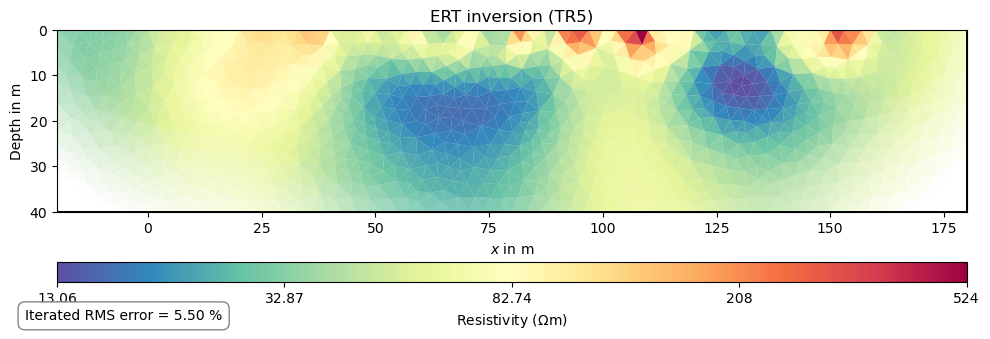

Done. (SAVE_IMAGES = True )


In [8]:
# ERT inversion and plotting (pyGIMLi 1.5.x)
# - Only ERT inversion and result visualization
# - Displays figures (plt.show()). Set SAVE_IMAGES=True to save PNGs too.
# - RMS error is printed at the bottom-left with padding and margin.
# - Added functionality to export inverted model data to Excel

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert

# -------------------------
# USER CONFIG
# -------------------------
ert_data_file = r"C:\Users\HOME\Desktop\ML Saline\CST\TR5.dat"

out_dir = r"C:\Users\HOME\Desktop\ML Saline\CST\Output"
os.makedirs(out_dir, exist_ok=True)

# Leave inversion params unchanged (as requested)
invert_kwargs = dict(
    lam=10.0,
    paraDX=0.3,
    paraMaxCellSize=8,
    paraDepth=40,
    quality=33.6,
    verbose=True
)

SAVE_IMAGES = True  # default: display only (set True to also save PNGs)

# -------------------------
# Robust pg.DataContainerERT
# -------------------------
def _read_numeric_lines(path):
    lines = []
    with open(path, "r", encoding="utf-8", errors="ignore") as fh:
        for raw in fh:
            s = raw.strip()
            if not s or s.startswith("#"):
                continue
            toks = s.split()
            if len(toks) < 5:
                continue
            ok = True
            for t in toks[:5]:
                try:
                    float(t.replace(",", "."))
                except Exception:
                    ok = False
                    break
            if ok:
                lines.append(" ".join(toks) + "\n")
    return lines

def load_tr1_dat_as_datacontainer(path, default_spacing=10.0):
    lines = _read_numeric_lines(path)
    if not lines:
        raise RuntimeError("No numeric lines found in TR5.dat")
    df = pd.read_csv(io.StringIO("".join(lines)), sep=r"\s+", header=None, engine="python")
    ncols = df.shape[1]

    if ncols >= 8:
        # x y z a b m n rhoa
        x = df.iloc[:, 0].astype(float).to_numpy()
        a = df.iloc[:, 3].astype(float).to_numpy()
        b = df.iloc[:, 4].astype(float).to_numpy()
        m = df.iloc[:, 5].astype(float).to_numpy()
        n = df.iloc[:, 6].astype(float).to_numpy()
        rhoa = df.iloc[:, 7].astype(float).to_numpy()
        unique_x = np.unique(x)
        use_x_positions = unique_x.size > 1
    else:
        # assume a b m n rhoa
        a = df.iloc[:, 0].astype(float).to_numpy()
        b = df.iloc[:, 1].astype(float).to_numpy()
        m = df.iloc[:, 2].astype(float).to_numpy()
        n = df.iloc[:, 3].astype(float).to_numpy()
        rhoa = df.iloc[:, 4].astype(float).to_numpy()
        unique_x = None
        use_x_positions = False

    a_idx = np.rint(a).astype(int)
    b_idx = np.rint(b).astype(int)
    m_idx = np.rint(m).astype(int)
    n_idx = np.rint(n).astype(int)

    if np.min([a_idx.min(), b_idx.min(), m_idx.min(), n_idx.min()]) >= 1:
        a_idx -= 1; b_idx -= 1; m_idx -= 1; n_idx -= 1

    max_elec = int(max(a_idx.max(), b_idx.max(), m_idx.max(), n_idx.max()))
    n_sensors = max_elec + 1

    if use_x_positions and unique_x.size == n_sensors:
        sensor_positions = np.column_stack((unique_x.astype(float), np.zeros(n_sensors, dtype=float)))
    else:
        sensor_positions = np.column_stack((np.arange(n_sensors, dtype=float) * default_spacing, np.zeros(n_sensors, dtype=float)))

    mask = (a_idx >= 0) & (a_idx < n_sensors) & (b_idx >= 0) & (b_idx < n_sensors) & \
           (m_idx >= 0) & (m_idx < n_sensors) & (n_idx >= 0) & (n_idx < n_sensors)
    if np.count_nonzero(~mask) > 0:
        print(f"Dropping {np.count_nonzero(~mask)} out-of-range measurements")
    a_idx, b_idx, m_idx, n_idx, rhoa = a_idx[mask], b_idx[mask], m_idx[mask], n_idx[mask], rhoa[mask]
    if rhoa.size == 0:
        raise RuntimeError("No valid measurements after filtering")

    data = pg.DataContainerERT()
    data.setSensorPositions(sensor_positions.tolist())
    data.resize(len(rhoa))
    data['a'] = a_idx
    data['b'] = b_idx
    data['m'] = m_idx
    data['n'] = n_idx
    data['rhoa'] = rhoa.astype(float)
    data['valid'] = np.ones(len(rhoa), dtype=int)

    try:
        if hasattr(data, "createGeometricFactors"):
            data.createGeometricFactors()
        else:
            data['k'] = np.array(ert.createGeometricFactors(data), dtype=float)
    except Exception as e:
        print("Warning: could not compute geometric factors:", e)
        data['k'] = np.ones(len(rhoa), dtype=float)

    try:
        kvals = np.array(data['k'], dtype=float)
        kvals[kvals == 0] = np.finfo(float).eps
        data['r'] = np.array(data['rhoa'], dtype=float) / kvals
    except Exception:
        pass

    try:
        if hasattr(data, "estimateError"):
            data.estimateError(relativeError=0.03)
        else:
            data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    except Exception:
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9

    print("Loaded TR1: electrodes =", data.sensorCount(), "measurements =", data.size())
    return data

# -------------------------
# Validate datacontainer
# -------------------------
def validate_datacontainer(data):
    if not data.haveData('rhoa'):
        raise RuntimeError("Data container has no 'rhoa'")
    if not data.haveData('k'):
        try:
            data.createGeometricFactors()
        except Exception:
            data['k'] = np.ones(data.size(), dtype=float)
    if not data.haveData('r'):
        try:
            kvals = np.array(data['k'], dtype=float)
            kvals[kvals == 0] = np.finfo(float).eps
            data['r'] = np.array(data['rhoa'], dtype=float) / kvals
        except Exception:
            pass
    if not data.haveData('err'):
        data['err'] = np.abs(np.array(data['rhoa'], dtype=float)) * 0.03 + 1e-9
    return data

# -------------------------
# MAIN: produce and show images
# -------------------------
def produce_images_and_show():
    # load ERT
    data = load_tr1_dat_as_datacontainer(ert_data_file)
    data = validate_datacontainer(data)

    # run inversion (unchanged)
    mgr = ert.ERTManager(data)
    print("Running inversion with params:", invert_kwargs)
    mgr.invert(**invert_kwargs)

    # Try retrieving misfit stats
    chi2 = mgr.chi2() if hasattr(mgr, 'chi2') else None
    try:
        rms = mgr.inv.relrms()
    except Exception:
        rms = None

    print("Inversion finished.")
    print("Chi² =", chi2 if chi2 is not None else "N/A")
    print("RMS error =", rms if rms is not None else "N/A")

    # ----- Export inverted model data to Excel -----
    if SAVE_IMAGES:
        try:
            # Get the inversion mesh and model values
            mesh = mgr.paraDomain  # Parametric domain mesh
            model_vals = mgr.model  # Resistivity values in Ohm-m

            # Extract cell centers (x, z coordinates)
            cells = mesh.cells()
            x_vals = []
            z_vals = []
            rho_vals = []
            for cell in cells:
                center = cell.center()
                x_vals.append(center.x())
                z_vals.append(center.y())  # Depth is negative in y-direction
                rho_vals.append(model_vals[cell.id()])

            # Create a DataFrame
            df_inv = pd.DataFrame({
                'X (m)': x_vals,
                'Depth (m)': z_vals,
                'Resistivity (Ohm-m)': rho_vals
            })

            # Save to Excel
            excel_path = os.path.join(out_dir, "TR5_Inverted_Model_Data.xlsx")
            df_inv.to_excel(excel_path, index=False)
            print(f"Inverted model data saved to: {excel_path}")
        except Exception as e:
            print(f"Error saving inverted data to Excel: {e}")

    # ----- ERT only -----
    fig = plt.figure(figsize=(10, 3.2))
    ax = fig.add_subplot(1, 1, 1)

    # Show result with fixed resistivity range (1-800 Ohm-m)
    mgr.showResult(ax=ax, cMap="Spectral_r", logScale=True, elecs=False) 
    ax.set_title("ERT inversion (TR5)")

    # Place RMS at bottom-left of the figure with padding and margin so it doesn't overlap other text
    if rms is not None:
        txt = f"Iterated RMS error = {rms:.2f} %"
        # use figure coordinates so it sits at bottom-left regardless of axis limits
        fig.text(
            0.03, 0.035,
            txt,
            ha="left",
            va="bottom",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.95, edgecolor="0.5")
        )

    if SAVE_IMAGES:
        fig.savefig(os.path.join(out_dir, "TR5_ERT.png"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    print("Done. (SAVE_IMAGES =", SAVE_IMAGES, ")")

if __name__ == "__main__":
    produce_images_and_show()